# **Trends on Crime using CTA Ridership Data Analysis**

**Research by:** Srijita Banerjee (sbane4@uic.edu)

**Description:** As part of our analysis of crime trends on the Chicago Transit Authority (CTA) system, this notebook investigates the relationship between spikes in crime incidents and patterns in daily ridership levels.

Building on broader crime analyses conducted by our team, which explored trends by month and crime type, this study focuses specifically on identifying dates with unusually high crime activity between 2010 and 2024.

This notebook analyzes how ridership responded around these spike dates and investigate real-world events or news articles that may explain changes in rider behavior. The goal is to determine whether significant crime events correlate with measurable impacts on public transit use.

In [1]:
# installing matplotlib
!pip install matplotlib

# installing seaborn
!pip install seaborn

In [2]:
# importing necessary libraries
import pandas as pd # for data loading and manipulation
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for enhanced plotting
import numpy as np # for numerical operations

from datetime import datetime # for handling and formatting dates

import warnings
warnings.filterwarnings('ignore') # to avoid warning messages while plotting or merging

In [3]:
# list of crime data files
crime_files = ['CTA_Crime_2011.csv',
               'CTA_Crime_2020.csv',
               'CTA_Crimes_2010.csv',
               'CTA_Crimes_2020.csv',
               'CTA_Crimes_2021.csv',
               'CTA_Crimes_2022.csv',
               'CTA_Crimes_2023.csv',
               'CTA_Crimes_2024.csv']

# loading and combining files
crime_df = pd.concat([pd.read_csv(file) for file in crime_files], ignore_index = True)

# parsing 'Date' column from String --> DateTime object
crime_df['Date'] = pd.to_datetime(crime_df['Date'])
#print(crime_df['Date'].dtype) #TESTING

In [4]:
# group crimes by day
crime_daily = crime_df.groupby(crime_df['Date'].dt.date).size().reset_index(name='crime_count')

#print(crime_daily.shape) #TESTING

## CTA Crime Data Statistics Analysis
This is everything inferred from doing the following calculations.


---


1. **Mean is: 12.47 and Standard Deviation is: 5.53**


*   About **12 crimes** happen any day on the CTA.
*   Most days are **within 5-6 crimes** up or down from that average.

*   So, big crime spikes should be days with **way more than normal**.


---



2. **Spike threshold is: 23.54** The *spike threshold* tells us that if any day had more than ~24 crimes, it's a high crime spike day.


---



3. We found a total of **104 days (out of 2585 days of the data collected)** where crime was unusually high (greater than ~23.54 crimes per day).


---



In [5]:
# calculating Daily Average Crime and Standard Deviation of Daily Crime
mean_crime = crime_daily['crime_count'].mean()
std_crime = crime_daily['crime_count'].std()

print(f"Average daily crime: {mean_crime:.2f}")
print(f"Standard deviation of daily crime: {std_crime:.2f}")

Average daily crime: 12.47
Standard deviation of daily crime: 5.53


In [6]:
# calculating spike threshold
threshold = mean_crime + 2 * std_crime
print(f"Crime spike threshold: {threshold:.2f}")

Crime spike threshold: 23.54


In [7]:
# filtering days with crime_count above threshold
spike_days = crime_daily[crime_daily['crime_count'] > threshold]
print(spike_days)

            Date  crime_count
6     2010-01-07           24
10    2010-01-11           26
13    2010-01-14           26
14    2010-01-15           31
18    2010-01-19           26
...          ...          ...
2336  2024-05-25           25
2342  2024-05-31           24
2349  2024-06-07           30
2441  2024-09-07           24
2451  2024-09-17           24

[104 rows x 2 columns]


## Relationship between Crime and Ridership
This section deals with inferring the relationship of Daily CTA Crime Data with Daily CTA Ridership Data with respect to **date of the crime occuring.**

---

We start with merging the data of crime rates with ridership data found in CTA public data repository.

In [8]:
# loading ridership data
ridership_df = pd.read_csv('CTA_Ridership_Daily_Boarding_Totals.csv')

# date column in ridership data parsed
ridership_df['service_date'] = pd.to_datetime(ridership_df['service_date'])

# keep only ridership records after 2010 (for now!)
ridership_df = ridership_df[ridership_df['service_date'] >= '2010-01-01']

ridership_df['service_date_only'] = ridership_df['service_date'].dt.date

# merge
merged_df = pd.merge(
    ridership_df,
    crime_daily,
    left_on='service_date_only',
    right_on = 'Date',
    how = 'left'
)

# fill missing crime counts
merged_df['crime_count'] = merged_df['crime_count'].fillna(0)

# dropping the extra 'Date' column
merged_df = merged_df.drop(columns = ['Date','service_date_only'])

print(merged_df.head())
print(merged_df.shape)

  service_date day_type     bus  rail_boardings  total_rides  crime_count
0   2010-01-01        U  348324          217060       565384         15.0
1   2010-01-02        A  484655          264011       748666         12.0
2   2010-01-03        U  354762          200944       555706          7.0
3   2010-01-04        W  938766          569397      1508163         12.0
4   2010-01-05        W  970860          589044      1559904         14.0
(5541, 6)


## Plotting **Crime Rate** & Ridership over **Time**
I have plotted the relationship of crime rates with CTA public transportation usage (overall) over the course of almost 15 years (2010 - 2024) The plot drawn shows increased crime rates across various timelines, such as years between **2010-2012 (pre-pandemic)**, and considerably somewhat lesser crime between the years **2020 and 2024 (post-pandemic)**.

     service_date  crime_count  total_rides
25     2010-01-26         38.0      1690887
635    2011-09-28         32.0      1812277
14     2010-01-15         31.0      1677327
102    2010-04-13         31.0      1711125
165    2010-06-15         31.0      1635029
270    2010-09-28         31.0      1781942
48     2010-02-18         31.0      1700119
20     2010-01-21         31.0      1696830
5333   2024-06-07         30.0       923009
3597   2020-01-06         30.0      1409870


<function matplotlib.pyplot.show(close=None, block=None)>

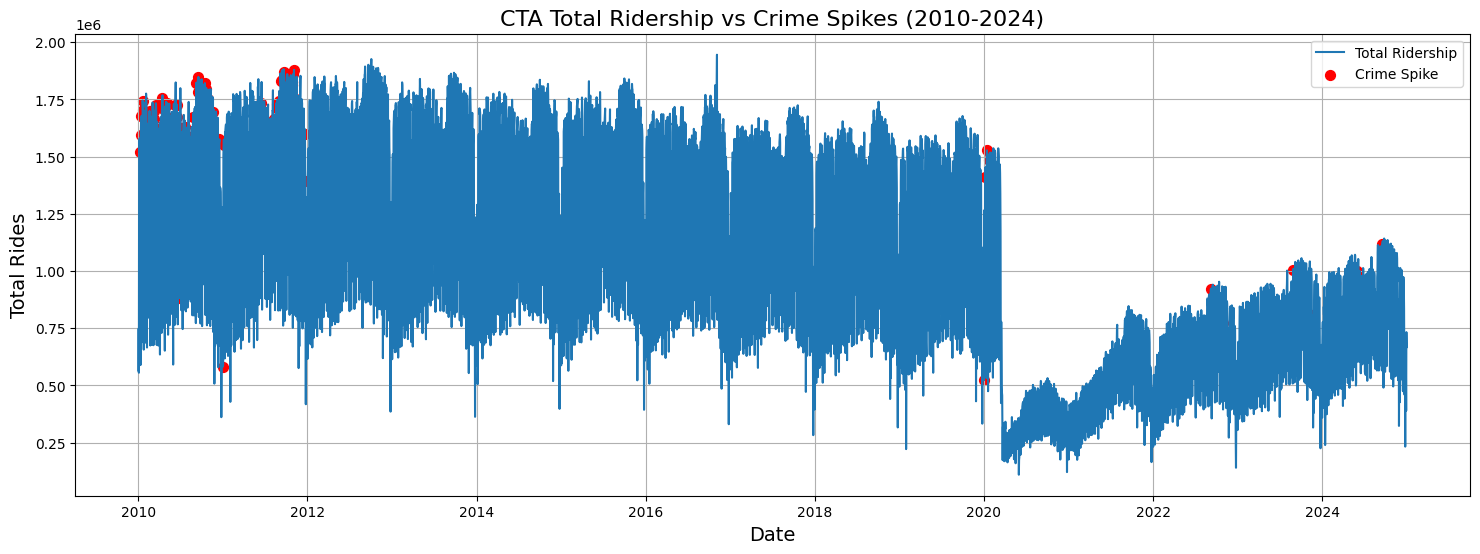

In [9]:
# setting crime spike threshold from before
crime_spike_threshold = threshold

# creating a boolean column for crime spikes
merged_df['is_crime_spike'] = merged_df['crime_count'] > crime_spike_threshold

# sort merged data by crime_count in descending order
spike_candidates = merged_df.sort_values('crime_count', ascending = False)

# view the top 10 spike days
print(spike_candidates[['service_date', 'crime_count', 'total_rides']].head(10))

# plotting now
plt.figure(figsize = (18,6))

# plotting total ridership
sns.lineplot(data = merged_df, x = 'service_date', y = 'total_rides', label = 'Total Ridership')

# crime spike days overlayed
spike_days = merged_df[merged_df['is_crime_spike']]
plt.scatter(spike_days['service_date'], spike_days['total_rides'], color = 'red', s = 50, label = 'Crime Spike')

# final add-ons to the plot
plt.title('CTA Total Ridership vs Crime Spikes (2010-2024)', fontsize = 16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Rides', fontsize=14)
plt.legend()
plt.grid(True)
plt.show

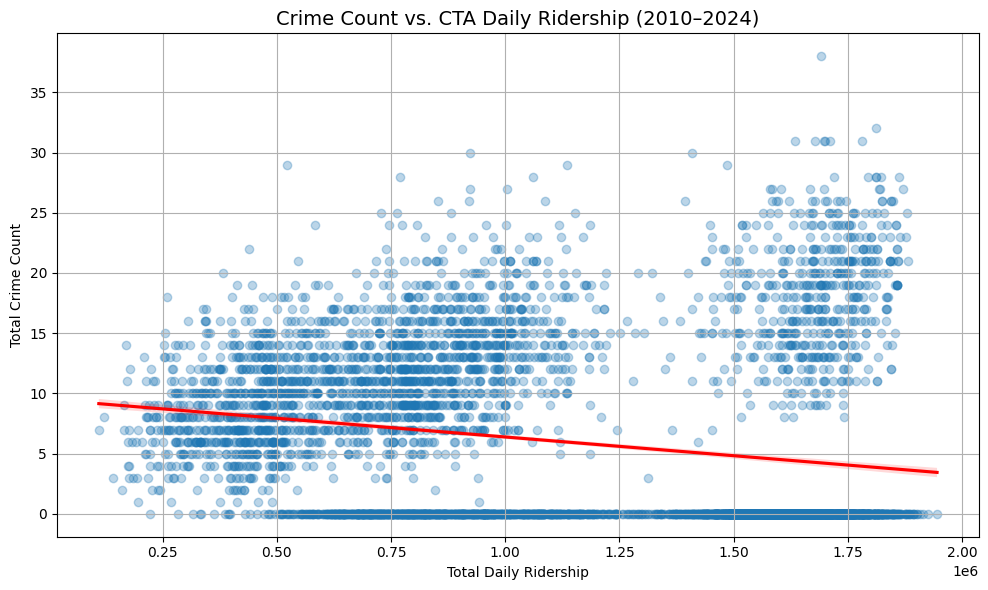

In [19]:
# scatterplot of crime vs. ridership
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.regplot(
    x=merged_df["total_rides"],
    y=merged_df["crime_count"],
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "red"}
)

plt.title("Crime Count vs. CTA Daily Ridership (2010–2024)", fontsize=14)
plt.xlabel("Total Daily Ridership")
plt.ylabel("Total Crime Count")
plt.grid(True)
plt.tight_layout()
plt.show()

As an additional statistical visualization, we plotted a **regression line** across daily crime count versus total CTA ridership from 2010 to 2024. The resulting line displayed **a slight negative slope**, suggesting **a weak inverse relationship—i.e., crime counts tended to be marginally lower on days with higher ridership**. However, the scatter of points shows **high variance, especially across mid-range and high ridership values, indicating that other confounding factors are likely influencing this relationship**. This reinforces the idea that while ridership volume might have some association with crime, *it cannot explain crime dynamics on its own without contextual factors like time of day, location, or socioeconomic context.*

## Crime Analysis of Certain Dates
On analyzing the above scatter plot, I have selected certain dates and analyzed the crime scene.

### CTA Crime on January 26th, 2010 [no media coverage]
On taking a glance at the dual plot, I have inferred the following:


*   January 26th, 2010 has the *highest crime rate* (~38 crimes committed)
*   There is a trend of increased crime dates that started 10 days before January 26th. This indicates a *trend of crime wave* in the CTA, it is **not** a one-day event.

**What exactly happened on January 26th, 2010?**

On January 26th, 2010, a total of **38 crimes** were reported in relation to CTA facilities. The majority of these incidents were thefts (10 cases), deceptive practices (7 cases), and narcotics-related offenses (6 cases). A significant number of these crimes (19 out of 38) occurred specifically on CTA platforms, with additional incidents reported on buses (7 cases) and trains (6 cases).

Although no major headline-grabbing incident was recorded for this date, the elevated crime count appears to be the result of multiple smaller-scale offenses concentrated around CTA boarding areas, particularly train platforms. This likely contributed to the observed spike without triggering a notable disruption in ridership patterns.


In [10]:
def plot_ridership_and_crime(date_str):
    date_of_interest = pd.to_datetime(date_str)

    zoom_df = merged_df[
        (merged_df['service_date'] >= date_of_interest - pd.Timedelta(days=10)) &
        (merged_df['service_date'] <= date_of_interest + pd.Timedelta(days=10))
    ]

    fig, ax1 = plt.subplots(figsize=(12,6))

    # plotting total rides (left y-axis)
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Total Riders', color=color)
    sns.lineplot(data=zoom_df, x='service_date', y='total_rides', marker='o', ax=ax1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.axvline(x=date_of_interest, color='red', linestyle='--', label='Crime Spike')
    ax1.legend(loc='upper left')

    # creating second y-axis for determining crime rates simultaneously
    ax2 = ax1.twinx()

    # Plot crime count manually (bars)
    color = 'tab:orange'
    ax2.set_ylabel('Crime Count', color=color)
    ax2.bar(zoom_df['service_date'], zoom_df['crime_count'], color=color, alpha=0.3, width=0.8)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f'CTA Ridership and Crime Around {date_str}')
    fig.tight_layout()
    plt.show()


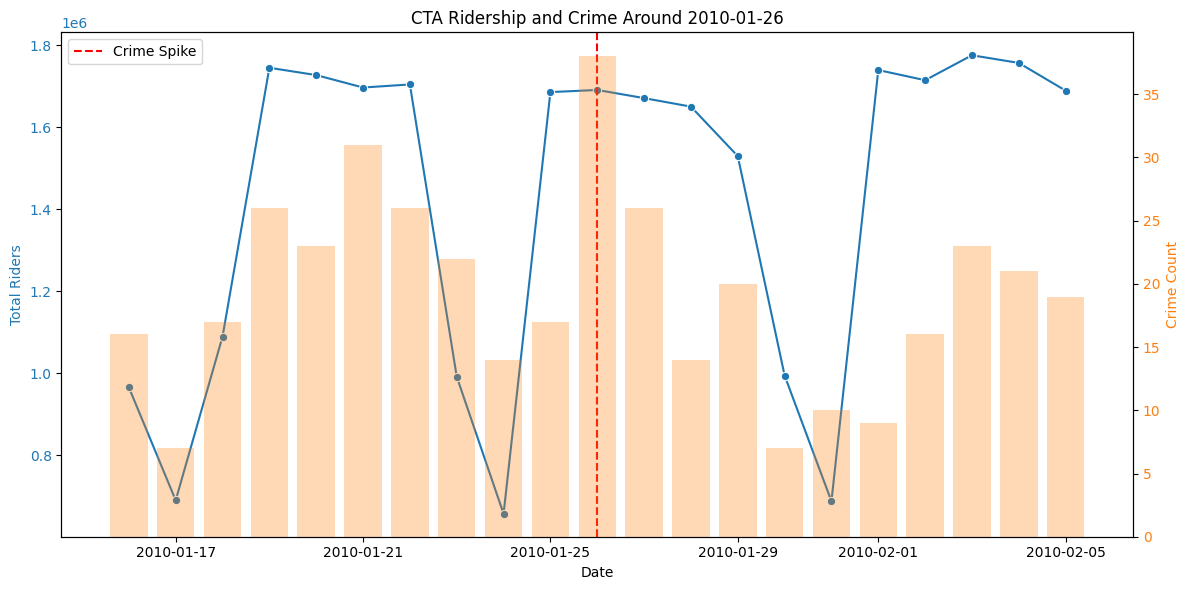

In [11]:
plot_ridership_and_crime('2010-01-26')

In [12]:
# filtering crimes for 2010-01-26

# double checking that 'Date' column in DateTime
crime_df['Date'] = pd.to_datetime(crime_df['Date'])

jan26_crimes = crime_df[crime_df['Date'].dt.date == pd.to_datetime('2010-01-26').date()]

# displaying summary
print (f"Total Crimes on January 26th, 2010: {len(jan26_crimes)}")
print("\nCrime Types Breakdown:")
print(jan26_crimes['Primary Type'].value_counts())

print("\nLocations breakdown:")
print(jan26_crimes['Location Description'].value_counts())


Total Crimes on January 26th, 2010: 38

Crime Types Breakdown:
Primary Type
THEFT                 10
DECEPTIVE PRACTICE     7
NARCOTICS              6
CRIMINAL DAMAGE        5
BATTERY                4
ROBBERY                2
ASSAULT                2
CRIMINAL TRESPASS      2
Name: count, dtype: int64

Locations breakdown:
Location Description
CTA PLATFORM                   19
CTA BUS                         7
CTA TRAIN                       6
CTA GARAGE / OTHER PROPERTY     4
CTA BUS STOP                    2
Name: count, dtype: int64


### CTA Crime on June 15th, 2010 [no media coverage]
On taking a glance at the dual plot I have inferred:


*   The crime count on June 15th, is the highest (~31 crimes committed)
*   No sharp immediate crash in ridership levels after the crime.


*   Slight dip in ridership numbers before June 15th, likely due to weekends, not crime
*   Crime counts steadily decline for the next 10 days after the big crime rate on June 15th.
*   Ridership numbers remain stable.

**What exactly happened on June 15th, 2010?**

On June 15th, 2010, a total of **31 crimes** were reported related to CTA facilities. The most frequent offenses were thefts (8 cases) and deceptive practices (8 cases), followed by batteries (5 cases) and robberies (4 cases). Incidents were predominantly concentrated on CTA platforms (13 cases), with additional reports involving CTA trains (6 cases) and buses (5 cases).

No major publicized incident was found in news archives for this date. The elevated crime count appears to stem from multiple smaller offenses occurring across different transit modes and boarding areas, contributing to the observed crime spike without triggering significant ridership disruptions.






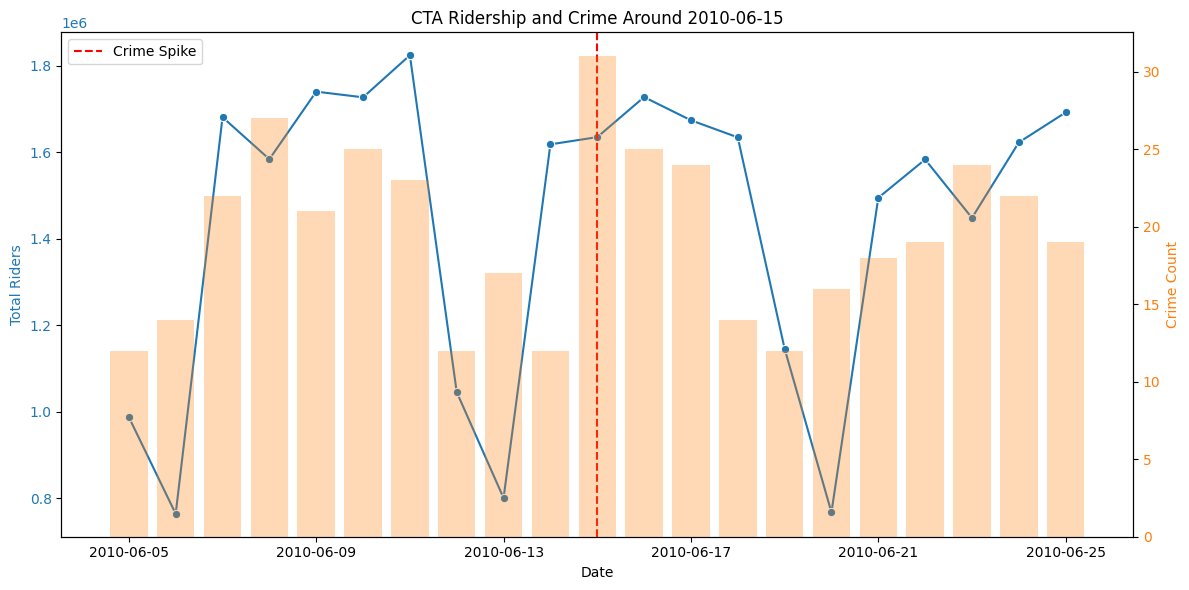

In [13]:
plot_ridership_and_crime('2010-06-15')

In [14]:
# filtering crimes that happened on 2010-06-15
june15_crimes = crime_df[crime_df['Date'].dt.date == pd.to_datetime('2010-06-15').date()]

# showing a quick summary
print(f"Total crimes on June 15th, 2010: {len(june15_crimes)}")
print("\nCrime types breakdown:")
print(june15_crimes['Primary Type'].value_counts())

print("\nLocations breakdown:")
print(june15_crimes['Location Description'].value_counts())

Total crimes on June 15th, 2010: 31

Crime types breakdown:
Primary Type
THEFT                 8
DECEPTIVE PRACTICE    8
BATTERY               5
ROBBERY               4
ASSAULT               2
NARCOTICS             2
CRIMINAL DAMAGE       1
STALKING              1
Name: count, dtype: int64

Locations breakdown:
Location Description
CTA PLATFORM                   13
CTA TRAIN                       6
CTA BUS                         5
CTA GARAGE / OTHER PROPERTY     4
CTA BUS STOP                    3
Name: count, dtype: int64


### CTA Crime on September 28th, 2011
On taking a glance at the dual plot I have inferred:


*   Ridership levels are overall pretty consistent - except for dates 2011-09-25 & 2011-10-02 (weekends)
*   Crime rates were considerably higher before the biggest crime spike on 09/28/2011, indicating *a trend in crime rate wave* -- **not** a one day event.


*   Crime rates slowly and steadily decreasing after September 28th, ridership numbers stay consistent.

**What happened on September 28th, 2011?**

On September 28th, 2011, a serious crime occurred on the CTA public transportation system. A man shot and killed three people on a Blue Line train at the Harlem stop, with a fourth victim dying later. The suspect, later identified as a Chicago resident, was apprehended and faced charges. [Block Club Chicago News Report](https://blockclubchicago.org/2024/09/03/chicago-man-charged-in-killing-of-4-people-on-blue-line-in-forest-park/)

[CBS News Report](https://www.cbsnews.com/chicago/news/cta-fatal-shooting-court/)






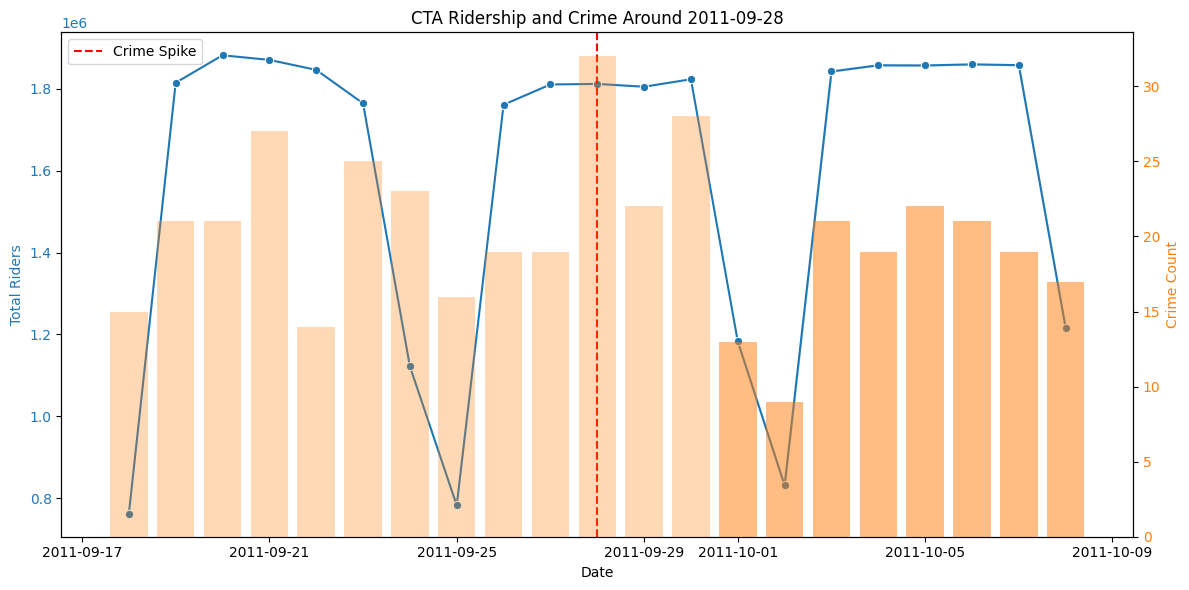

In [15]:
plot_ridership_and_crime('2011-09-28')

### CTA Crime on January 23rd, 2020
On taking a glance at the dual plot I have inferred:



*   The crime count spiked on January 23, 2020, but not dramatically compared to nearby days.

*   Ridership stayed very flat and stable — even right after the spike, no visible drop.

*   Crime counts remain steady after 1/23 — no major escalation or crash.


**What happened on January 23rd, 2020?**

On January 23, 2020, a Chicago man named Antoine Jackson was arrested for a Red Line train attack and robbery that occurred earlier that month. He was charged with multiple felonies, including aggravated criminal sexual abuse, robbery, and aggravated battery.

[WTTW News Report](https://news.wttw.com/2020/01/23/chicago-man-arrested-red-line-attack-robbery#:~:text=Matt%20Masterson%20%7C%20January%2023%2C%202020,train%20at%20the%20Morse%20stop.)

[X Post by Chicago Police Official Profile](https://x.com/Chicago_Police/status/1220386953536794629?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E1220386953536794629%7Ctwgr%5Eb8a1a4a938b1bfd1df754d3c586c18b11835277a%7Ctwcon%5Es1_&ref_url=https%3A%2F%2Fnews.wttw.com%2F2020%2F01%2F23%2Fchicago-man-arrested-red-line-attack-robbery)



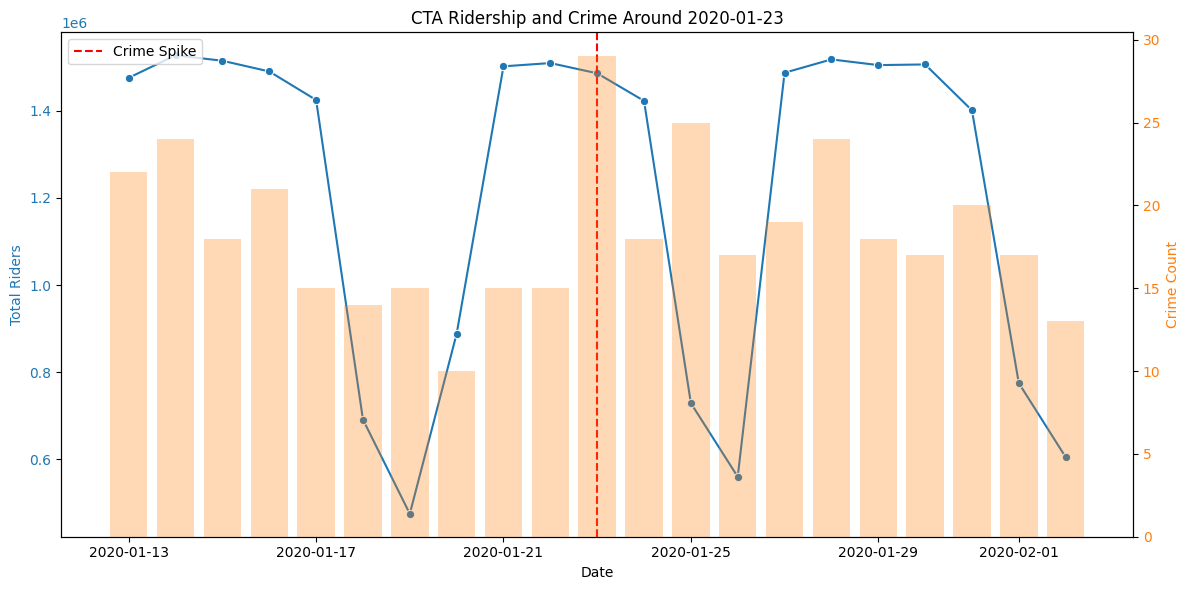

In [16]:
plot_ridership_and_crime('2020-01-23')

### CTA Crime on September 25th, 2023
On taking a glance at the dual plot I have inferred:


*   There's a clear crime spike on September 25, 2023 — the highest bar in the whole window (~27 incidents).
*   Ridership actually rises just before the spike and remains steady right after — no crash.

*   After September 25, crime levels decline gradually over the following days — not a sudden drop.
*   Despite high crime counts, rider behavior remains unaffected — people kept using the CTA without significant disruption.

**What happened on September 25th, 2023?**

No specific violent crime detected that day.Battery, deceptive practices, and cases involving narcotics were among the most common crimes reported at CTA stations and platforms in 2023.





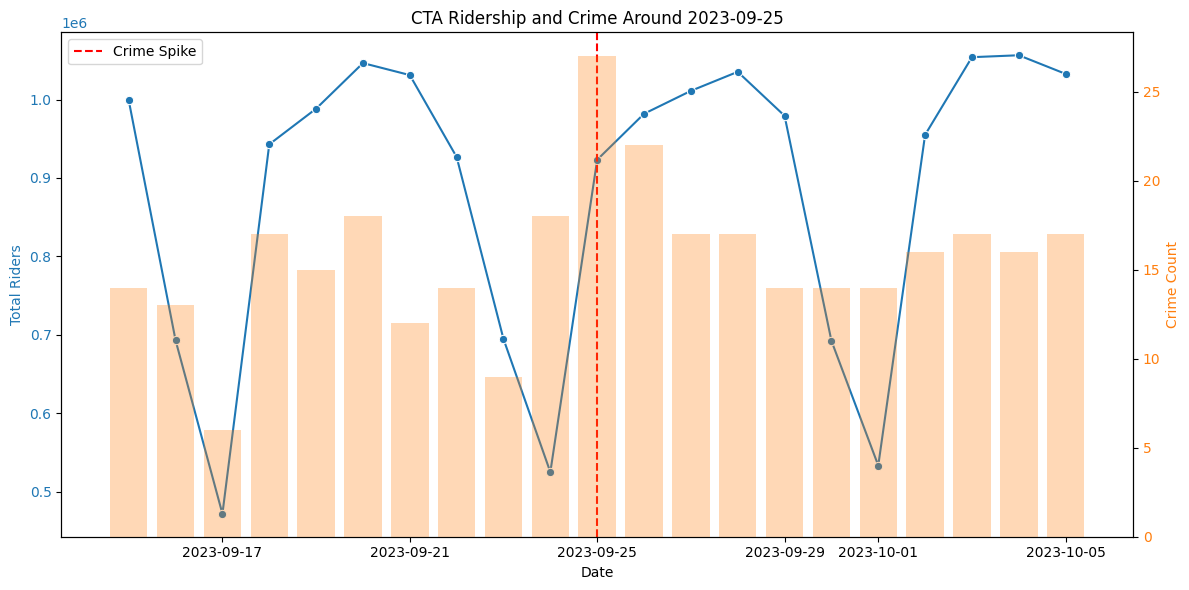

In [17]:
plot_ridership_and_crime('2023-09-25')

### CTA Crime on June 7th, 2024 (**interesting** 🤔)
On taking a glance at the dual plot I have inferred:

*   Very high crime spike on June 7, 2024 — clearly visible, highest bar (~30 incidents).
*   Ridership on June 7 was already lower than typical weekdays — a noticeable dip before crime peaked.
*   After the spike, ridership continued to decline slightly — not a full crash, but no big rebound either.


*   Crime spike **coincided** with lower ridership, **not caused by it** — meaning the system was already less crowded even before the spike!
*   *Possible Factor*: June 7 is close to summer weekends — lower ridership could partly be summer travel patterns, Friday effect, or early summer vacations.

**What happened on June 7th, 2024?**

No specific crime mentioned in CTA search results, however the following information seemed to tally with the bar plots here:


*   The raw number of violent crimes reported through June 2024 was 310, up from 284 through June 2023. [Transit Talent Article](https://www.transittalent.com/articles/index.cfm?story=CTA_Violent_Crime_Remains_High_9-9-2024)
*   There were about 5.1 violent crimes per million rides through June 2024, which is comparable to the same period in 2023 but higher than pre-pandemic levels. [Yahoo News Article](https://www.yahoo.com/news/cta-grapples-crime-altercation-red-005000536.html?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAEFzXt5JsPRSJ8_FWT5WKVxA8QzTdBimu_7c-h4QJ8g58E921CzyG6JFTaZ4iQlrElDWZp5FHf58sbdPMgF6fRIbzSl6MqlYMg102ML8JFcVNOo_KWlckjCACJHBBBNYElqehLBFMB7vi_a9E-0o_Zaulw0R18Jax5yqmkuQ8B53)
*   The **Green Line** experienced the highest crime rate per 100,000 rides. [Illinois Policy News Article](https://www.illinoispolicy.org/where-on-chicago-transit-authority-are-you-most-likely-to-be-crime-victim/#:~:text=CTA%20Green%20Line%20riders%20experienced,October%202023%20and%20September%202024.&text=Only%20includes%20CTA%20stations%20and%20platforms%20located%20inside%20Chicago%20city%20limits.&text=Citywide%2C%20about%201.3%20out%20of,the%20prior%2012%2Dmonth%20period.)







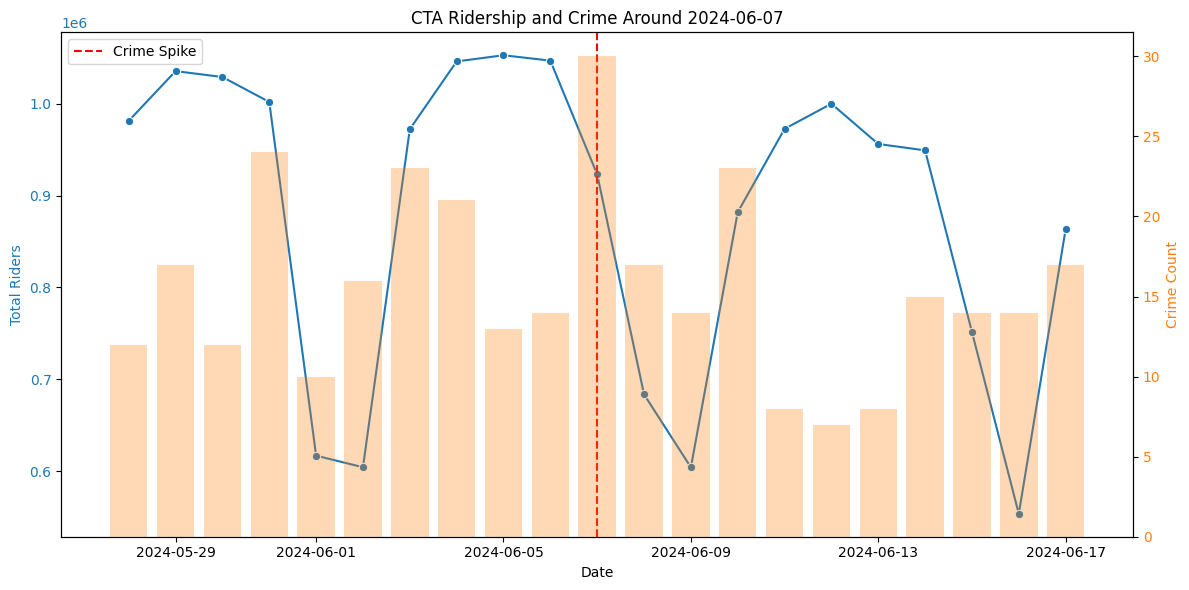

In [18]:
plot_ridership_and_crime('2024-06-07')

## Overall Conclusion

Through this analysis, we explored how crime spikes correlated with ridership patterns on the CTA system between 2010 and 2024. While crime surges did not always directly cause immediate drops in ridership, several instances showed that high crime days coincided with *natural seasonal dips* or *continued low ridership levels*. Smaller incidents, particularly **thefts, deceptive practices, and assaults** at CTA platforms, were major contributors to daily crime spikes rather than large-scale events. This suggests that *while individual crime events may not drastically disrupt transit usage, maintaining a safe environment at boarding locations remains critical for sustaining rider trust and confidence in the CTA system.*
